# Import Libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Load Dataset

In [59]:
# Load the dataset
df = pd.read_csv('../../datasets/telco_customer_churn_clean.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
df.head()

Dataset loaded successfully!
Shape: (7032, 21)


,customer_id,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,plan_type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data Cleaning

In [60]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Convert TotalCharges to numeric, handle errors
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

# Fill missing TotalCharges with 0 (assuming new customers)
df['total_charges'].fillna(0, inplace=True)

# Remove duplicates if any
df.drop_duplicates(inplace=True)

# Check data types
print("\nData types:")
print(df.dtypes)

# Basic statistics
df.describe()

Missing values:
customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure_months        0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
plan_type            0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

Data types:
customer_id           object
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure_months          int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
plan_type             object
paperless_b

C:\Users\danis\AppData\Local\Temp\ipykernel_2332\365645649.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_charges'].fillna(0, inplace=True)


,senior_citizen,tenure_months,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


# Exploratory Data Analysis

Overall churn rate: 26.58%


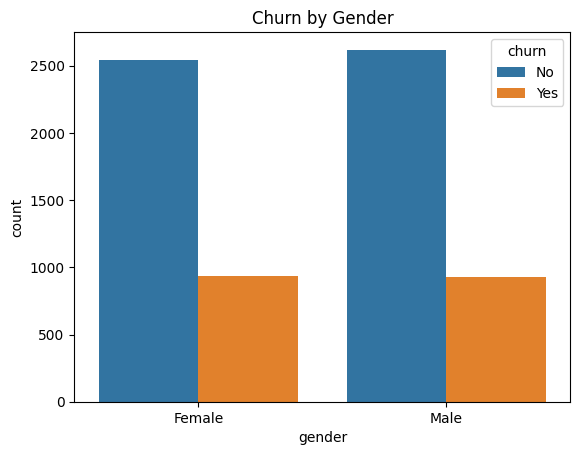

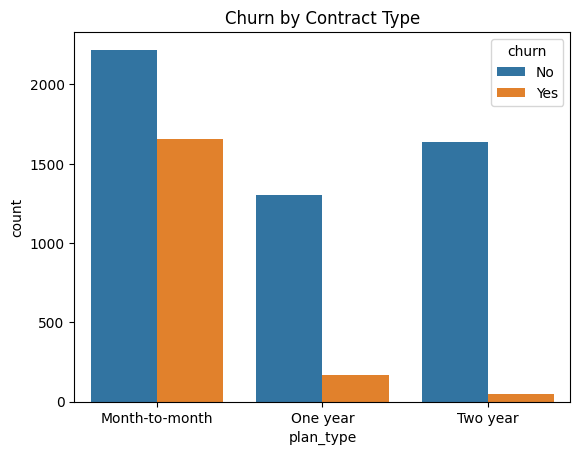

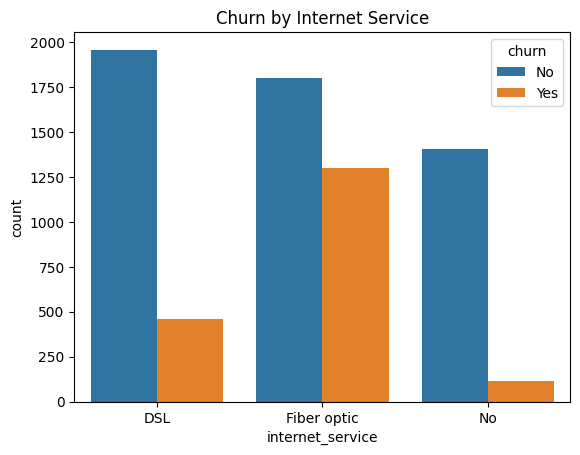

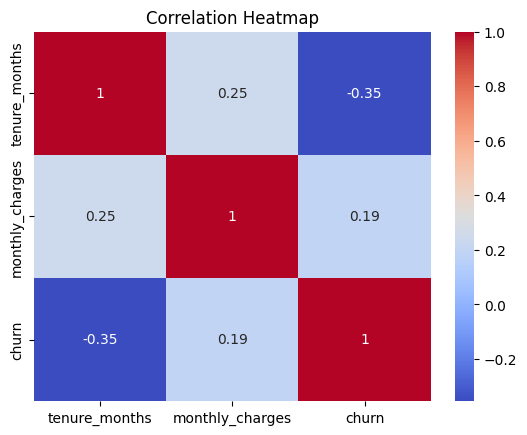

In [61]:
# Overall churn rate
churn_rate = df['churn'].value_counts(normalize=True)['Yes'] * 100
print(f"Overall churn rate: {churn_rate:.2f}%")

# Churn by gender
sns.countplot(x='gender', hue='churn', data=df)
plt.title('Churn by Gender')
plt.show()

# Churn by contract type
sns.countplot(x='plan_type', hue='churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

# Churn by internet service
sns.countplot(x='internet_service', hue='churn', data=df)
plt.title('Churn by Internet Service')
plt.show()

# Correlation heatmap for numeric columns
df_numeric = df.copy()
df_numeric['churn'] = df_numeric['churn'].map({'Yes': 1, 'No': 0})

numeric_cols = ['tenure_months', 'monthly_charges', 'churn']
corr = df_numeric[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Feature Engineering

In [62]:
# Create tenure buckets
df['tenure_bucket'] = pd.cut(df['tenure_months'],
                             bins=[0, 3, 6, 12, df['tenure_months'].max()],
                             labels=['0-3 months', '4-6 months', '7-12 months', '12+ months'])

# Encode categorical variables
le = LabelEncoder()

categorical_cols = ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines',
                    'internet_service', 'online_security', 'online_backup', 'device_protection',
                    'tech_support', 'streaming_tv', 'streaming_movies', 'plan_type',
                    'paperless_billing', 'payment_method', 'tenure_bucket']

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Prepare features and target
X = df.drop(['customer_id', 'churn', 'total_charges'], axis=1)
y = df['churn'].map({'Yes': 1, 'No': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Prepare features and target
X = df.drop(['customer_id', 'churn', 'total_charges'], axis=1)  # Drop ID and target, TotalCharges might be leaky
y = df['churn'].map({'Yes': 1, 'No': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Churn Prediction Model

In [63]:
# Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



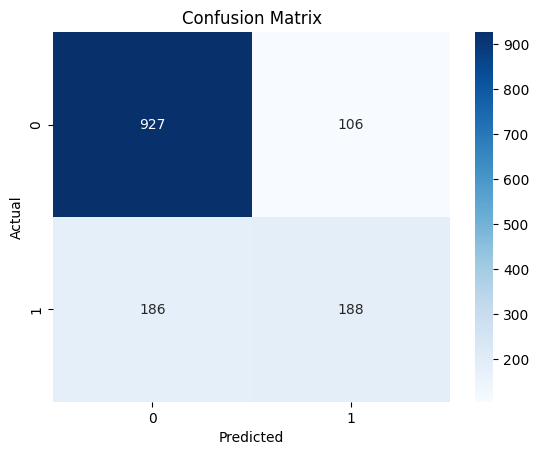

ROC-AUC Score: 0.83
Top 10 Feature Importances:
              feature  importance
15  paperless_billing    0.304679
1      senior_citizen    0.278870
7    internet_service    0.261282
6      multiple_lines    0.086952
2             partner    0.081075
16     payment_method    0.038975
13   streaming_movies    0.038221
12       streaming_tv    0.031028
17    monthly_charges    0.028602
0              gender   -0.030952


In [64]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Feature importance (coefficients for Logistic Regression)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.coef_[0]})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("Top 10 Feature Importances:")
print(feature_importance.head(10))

# Visualizations

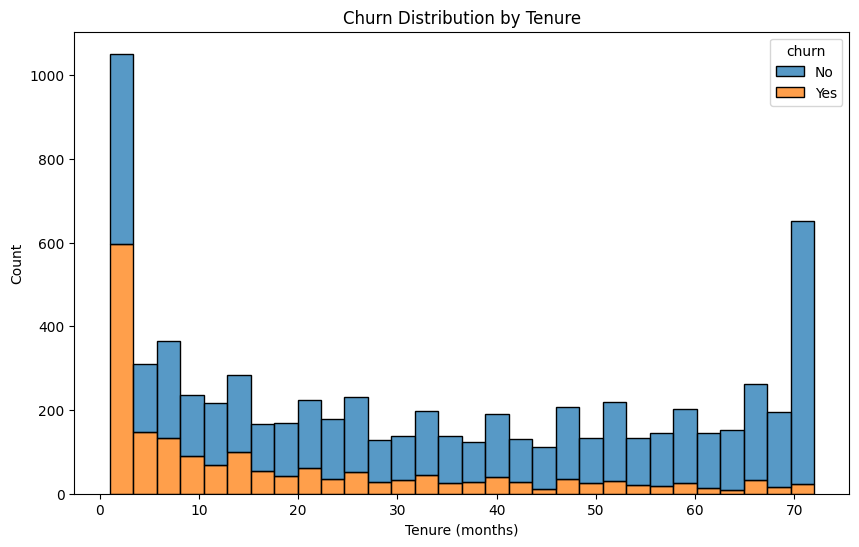

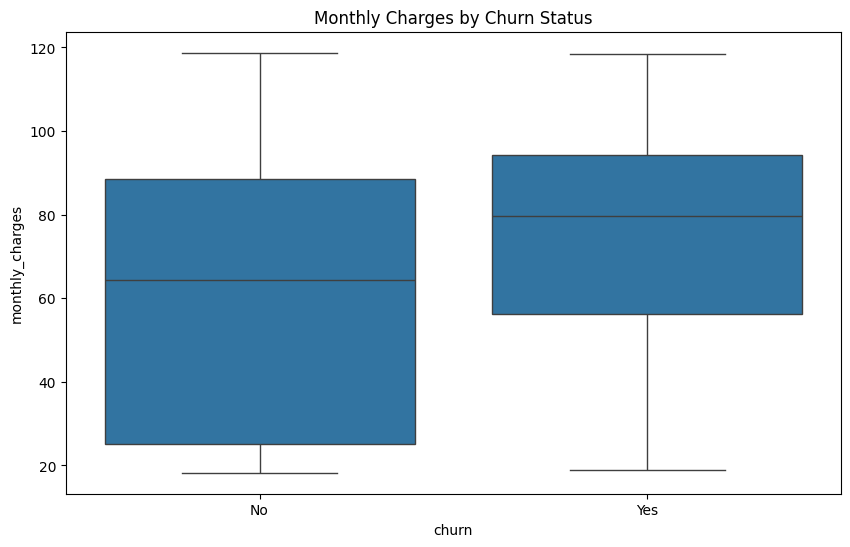

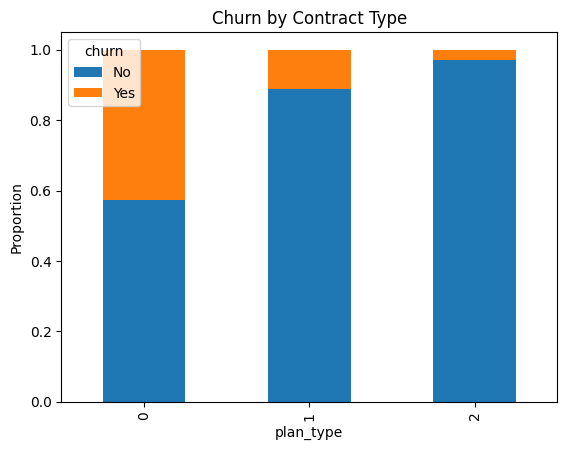

In [65]:
# Churn rate by tenure
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure_months', hue='churn', multiple='stack', bins=30)
plt.title('Churn Distribution by Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Count')
plt.show()

# Monthly charges distribution by churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='monthly_charges', data=df)
plt.title('Monthly Charges by Churn Status')
plt.show()

# Churn by contract type (percentage)
contract_churn = df.groupby('plan_type')['churn'].value_counts(normalize=True).unstack().fillna(0)
contract_churn.plot(kind='bar', stacked=True)
plt.title('Churn by Contract Type')
plt.ylabel('Proportion')
plt.show()

# Insights and Recommendations

## Key Findings
- Customers with month-to-month contracts are more likely to churn compared to those with longer-term contracts.
- Higher monthly charges correlate with higher churn rates, indicating price sensitivity.
- Early tenure customers (0-3 months) have the highest churn rate.

## Recommendations
- Encourage customers to switch to longer-term contracts with incentives like discounts.
- Review pricing strategy to ensure competitiveness, especially for high-charge plans.
- Implement targeted onboarding and support for new customers to improve retention in the first few months.